In [1]:
# Import necessary modules
import py_ncdiff
import os
import logging
import numpy as np
%matplotlib inline

# Setup logging so info / debug -> stdout instead of stderr
py_ncdiff.init_logging()
logger = logging.getLogger(__name__)

In [2]:
baseline_case = 'C1850ECO.T62_g37.ciso.trunk_20180716'
new_case = 'C1850ECO.T62_g37.ciso.trunk_20180705'

root_dir = os.path.join(os.path.sep,'glade','scratch_new','mlevy')
if not os.path.isdir(root_dir):
    root_dir = os.path.join(os.path.sep,'sshfs') + root_dir

if os.path.isdir(os.path.join(root_dir,new_case)):
    file1 = os.path.join(root_dir,new_case,'run',new_case+'.pop.h.0001-01-03.nc')
    file2 = os.path.join(root_dir,'baselines','single_run',baseline_case+'.pop.h.0001-01-03.nc')
    nc_test = py_ncdiff.netCDF_comp_class(file1, file2,quiet=True,is_POP=True)
else:
    logger.error("Can not find root directory (may need to mount sshfs drive)")


/glade/work/mlevy/miniconda3/envs/pangeo/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Comparing /glade/scratch_new/mlevy/C1850ECO.T62_g37.ciso.trunk_20180705/run/C1850ECO.T62_g37.ciso.trunk_20180705.pop.h.0001-01-03.nc and /glade/scratch_new/mlevy/baselines/single_run/C1850ECO.T62_g37.ciso.trunk_20180716.pop.h.0001-01-03.nc
-----
Baseline modified: Thu Jul 19 11:43:37 2018
New file modified: Thu Jul 19 11:08:57 2018
-----


In [ ]:
nc_test.compare_variable_names()
nc_test.compare_variable_type_and_dims()
nc_test.compare_metadata()
nc_test.compare_values()
# nc_test.diff_vars
err_cnt = nc_test.parse_results()

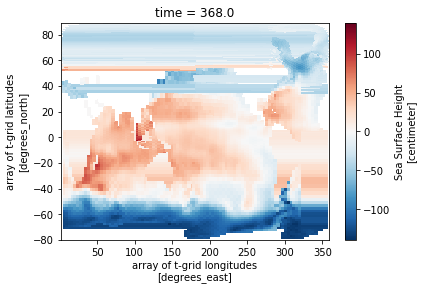

In [3]:
# Pick variable to plot (kwargs will look only at surface for 3D fields)
var_to_plot = 'SSH'
kwargs = dict()
kwargs['time']=0
if 'z_t' in nc_test.baseline['ds'][var_to_plot].coords:
    kwargs['z_t']=0

ds_baseline = nc_test.baseline['ds']
# var_new_file = nc_test.new_file['ds'][var_to_plot]
# var_difference = nc_var_baseline - var_new_file
ds_baseline[var_to_plot].isel(**kwargs).plot.pcolormesh(x='TLONG',y='TLAT')
#var_new_file.isel(z_t=0).plot()
#var_difference.isel(z_t=0).plot()